Import balíčků

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.feature_selection import RFECV
from itertools import compress
from scipy import stats
from scipy.stats import loguniform

Load dat

In [122]:
DF_HEART_RAW = pd.read_csv("https://raw.githubusercontent.com/Doll03/4IZ580/PROD/data/heart.csv", sep=",")

Zpracování dat

In [123]:
# Ošetření chybějících dat
# Některé datové typy je potřeba upravit do požadované podoby
class preprocess_df:
    def __init__(self,df,column = None):
        self.column = column
        self.df = df
    
    def get_dtypes(self):
        dtype = self.df[f'{self.column}'].dtype
        tmp_dict = {'column':[self.column],'dtype':[dtype]}
        return tmp_dict

    def check_null_values(self):
        null_count = self.df[f'{self.column}'].isnull().sum()
        tmp_dict = {'column':[self.column],'null_count':[null_count]}
        return tmp_dict
    
    def check_duplication(self):
        if self.df.duplicated().sum() > 0:
            print('duplicates detected and dropped')
            self.df.drop_duplicates(keep='first',inplace=True)
            self.df.reset_index(drop=True,inplace=True)
        else:
            print('no duplicates were detected')
    
    def change_dtype(self,dtype):
        try:
            self.df[f'{self.column}'] = self.df[f'{self.column}'].astype(f'{dtype}')
            print(f'{self.column} was properly casted to {dtype}')
        except:
            print(f'{self.column} failed to be casted to {dtype}')
        
def check_df(df):
    df_info = pd.DataFrame()
    for column in list(df.columns):
        column_dtype = pd.DataFrame.from_dict(preprocess_df(df=df,column=column).get_dtypes())
        column_null_values = pd.DataFrame.from_dict(preprocess_df(df=df,column=column).check_null_values())
        df_info = df_info.append(pd.merge(column_dtype,column_null_values,on='column',how='outer'))
    preprocess_df(df=df).check_duplication()
    return df_info

DF_INFO = check_df(df=DF_HEART_RAW)
print(DF_INFO)
DESIRED_DTYPES = pd.DataFrame(data={
    'column':['sex','cp','fbs','restecg','exng','slp','caa','thall','output'],
    'desired_dtype':['category','category','bool','category','bool','category','category','category','bool']})

def clean_df(df):
    df = df.copy()
    for _,column in DESIRED_DTYPES.iterrows():
        preprocess_df(df=df,column=column['column']).change_dtype(dtype=column['desired_dtype'])
    return df

DF_CLEAN = clean_df(df=DF_HEART_RAW)

duplicates detected and dropped
     column    dtype  null_count
0       age    int64           0
0       sex    int64           0
0        cp    int64           0
0    trtbps    int64           0
0      chol    int64           0
0       fbs    int64           0
0   restecg    int64           0
0  thalachh    int64           0
0      exng    int64           0
0   oldpeak  float64           0
0       slp    int64           0
0       caa    int64           0
0     thall    int64           0
0    output    int64           0
sex was properly casted to category
cp was properly casted to category
fbs was properly casted to bool
restecg was properly casted to category
exng was properly casted to bool
slp was properly casted to category
caa was properly casted to category
thall was properly casted to category
output was properly casted to bool


C:\Users\user\AppData\Local\Temp\ipykernel_1884\3180202172.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info = df_info.append(pd.merge(column_dtype,column_null_values,on='column',how='outer'))
C:\Users\user\AppData\Local\Temp\ipykernel_1884\3180202172.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info = df_info.append(pd.merge(column_dtype,column_null_values,on='column',how='outer'))
C:\Users\user\AppData\Local\Temp\ipykernel_1884\3180202172.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info = df_info.append(pd.merge(column_dtype,column_null_values,on='column',how='outer'))
C:\Users\user\AppData\Local\Temp\ipykernel_1884\3180202172.py:38: FutureWarning: The frame.append method is deprecated an

Kontrola distribuce cílové proměnné

True     0.543046
False    0.456954
Name: output, dtype: float64


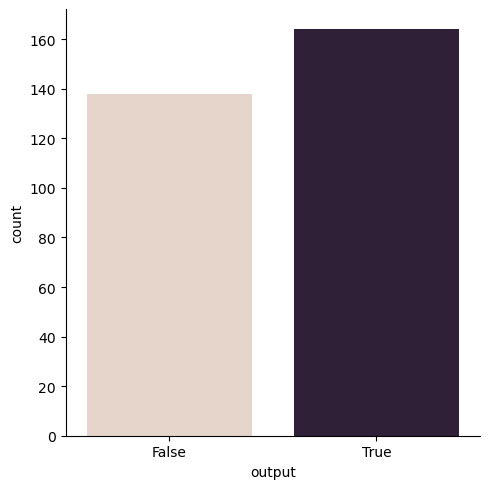

In [124]:
# histogram 
print(DF_CLEAN["output"].value_counts(normalize=True))
sns.catplot(data = DF_CLEAN, x = "output", kind = "count", palette = "ch:.11")

#Sledovaná proměnná "output" je poměrně vyrovnaná takže není třeba dataset dále upravovat

Data split

In [137]:
seed = 333 

TARGET = DF_CLEAN["output"]#sledovanaá proměnná
FEATURE = DF_CLEAN.drop("output", axis= 1)#vysvětlující proměnné

VARIABLE_NAMES = FEATURE.columns.to_list()

X = DF_CLEAN[VARIABLE_NAMES]
Y = TARGET

In [138]:
#rozdělení datasetu na trénovací, validační a testovací dataset
_, X_test, __, y_test = train_test_split(X, Y, test_size=0.15, random_state = seed, stratify=Y)
X_train, X_valid, y_train, y_valid = train_test_split(_, __, test_size=0.176, random_state = seed, stratify=__)

#kontrola
print("X_test", X_test.shape[0])
print("y_test", y_test.shape[0])
print("X_train", X_train.shape[0])
print("y_train", y_train.shape[0])
print("X_valid", X_valid.shape[0])
print("y_valid", y_valid.shape[0])

X_test 46
y_test 46
X_train 210
y_train 210
X_valid 46
y_valid 46


In [139]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=seed) # CV je nastavena na n_splits=3, n_repeats=2 z důvodu snížení výpočetní složitosti

In [128]:
# Definujeme si 3 modely které budeme trénovat
dt = DecisionTreeClassifier(random_state = seed)
rf = RandomForestClassifier(random_state = seed)
lr = LogisticRegression(random_state = seed)


Hyperparameter Space

In [129]:
#Každému z modelů definujeme hyperparametrový prostor, ze kterých budeme v příštích krocích vybírat optimální sady hyperparametrů 

#Hyperparameter space - Logistic regression
lr_space = dict()
lr_space['solver'] = ['newton-cg', 'lbfgs', "sag"]
lr_space['penalty'] = ['l2']
lr_space['C'] = loguniform(1e-5, 10000)
lr_space["max_iter"] = list(range(100,10000,100))

#Hyperparameter space - Decision Tree
dt_space = dict()
dt_space["criterion"] = ["gini", "entropy", "log_loss"]
dt_space["max_depth"] = list(range(4,100,2))
dt_space["max_features"] = list(range(2,30,2)) + ['sqrt', "log2"]
#Hyperparameter space - Random Forest
rf_space = dict()
rf_space["criterion"] = ["gini", "entropy", "log_loss"]
rf_space["max_depth"] = list(range(4,100,2))
rf_space["max_features"] = list(range(2,30,2)) + ['sqrt', "log2"]
rf_space["n_estimators"] = list(range(100,1000,50))





První kolo ladění parametrů jednotlivých modelů

In [140]:
#Random_Forest
r_search_rf = RandomizedSearchCV(estimator = rf, param_distributions= rf_space, cv=cv, random_state=seed, scoring = "f1")
r_search_rf.fit(X_train, y_train)
rs_rf_param = r_search_rf.best_params_

#Decision_Tree
r_search_dt = RandomizedSearchCV(estimator = dt, param_distributions= dt_space, cv=cv, random_state=seed, scoring = "f1")
r_search_dt.fit(X_train, y_train)
rs_dt_param = r_search_dt.best_params_

#Logistic_Regression
r_search_lr = RandomizedSearchCV(estimator = lr, param_distributions= lr_space, cv=cv, random_state=seed, scoring = "f1")
r_search_lr.fit(X_train, y_train)
rs_lr_param = r_search_lr.best_params_

#Pomocí funkce RandomizedSearchCV byly vybrány optimální sady parametrů pro každý model

print("Random_Forest:", rs_rf_param)
print("Decision_Tree:", rs_dt_param)
print("Logistic_Regression:", rs_lr_param)


Random_Forest: {'n_estimators': 800, 'max_features': 2, 'max_depth': 74, 'criterion': 'entropy'}
Decision_Tree: {'max_features': 8, 'max_depth': 88, 'criterion': 'entropy'}
Logistic_Regression: {'C': 0.7755678240567525, 'max_iter': 7800, 'penalty': 'l2', 'solver': 'sag'}


In [141]:
#Ulozeni nejlepsich sad parameteru 
b_rf_est = r_search_rf.best_estimator_
b_dt_est = r_search_dt.best_estimator_
b_lr_est = r_search_lr.best_estimator_

Feature Selection

In [142]:
#Random_Forest
rf_feat_sel = RFECV(estimator=b_rf_est, cv=cv, scoring="f1", n_jobs = -1)
rf_feat_sel.fit(X_train, y_train)

#Decision_Tree
dt_feat_sel = RFECV(estimator=b_dt_est, cv=cv, scoring="f1", n_jobs = -1)
dt_feat_sel.fit(X_train, y_train)

#Logistic_Regression
lr_feat_sel = RFECV(estimator=b_lr_est, cv=cv, scoring="f1", n_jobs = -1)
lr_feat_sel.fit(X_train, y_train)

# Feature selection je výberproměných, které se použijí ke konstrukci predikčního modelu. 
# Děláme ji abychom snížili náročnost na modelování a zlepšili výkonnost modelu.
# Používáme funkci RFECV (Recursive feature elimination with cross-validation). 
# Tato metoda postupně eliminuje ty proměnné, které mají nízký příspěvek k predikci.

RFECV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=333),
      estimator=LogisticRegression(C=0.7755678240567525, max_iter=7800,
                                   random_state=333, solver='sag'),
      n_jobs=-1, scoring='f1')

In [143]:
#Ulozeni vybranych features do listu
rf_selected = list(compress(X_train.columns.tolist(), rf_feat_sel.support_.tolist()))
dt_selected = list(compress(X_train.columns.tolist(), dt_feat_sel.support_.tolist()))
lr_selected = list(compress(X_train.columns.tolist(), lr_feat_sel.support_.tolist()))

Druhé kolo ladění parametrů, tentokrát pouze na předem vybraných features

In [147]:

#Random_Forest
r_search_rf_final = RandomizedSearchCV(estimator = rf, param_distributions= rf_space, cv= cv, random_state=seed, scoring = "f1", n_jobs = -1,verbose = 1)
r_search_rf_final.fit(X_train[rf_selected], y_train)
b_rf_est_final = r_search_rf_final.best_estimator_

rf_valid_preds = b_rf_est_final.predict_proba(X_valid[rf_selected])[:,1]
rf_valid_auc = roc_auc_score(y_valid, rf_valid_preds)

#Decision_Tree
r_search_dt_final = RandomizedSearchCV(estimator = dt, param_distributions= dt_space , cv= cv, random_state=seed, scoring = "f1", n_jobs = -1,verbose = 1)
r_search_dt_final.fit(X_train[dt_selected], y_train)
b_dt_est_final = r_search_dt_final.best_estimator_

dt_valid_preds = b_dt_est_final.predict_proba(X_valid[dt_selected])[:,1]
dt_valid_auc = roc_auc_score(y_valid, dt_valid_preds)

#Logistic_Regression
r_search_lr_final = RandomizedSearchCV(estimator = lr, param_distributions= lr_space , cv= cv, random_state=seed, scoring = "f1", n_jobs = -1,verbose = 1)
r_search_lr_final.fit(X_train[lr_selected], y_train)
b_lr_est_final = r_search_lr_final.best_estimator_

lr_valid_preds = b_lr_est_final.predict_proba(X_valid[lr_selected])[:,1]
lr_valid_auc = roc_auc_score(y_valid, lr_valid_preds)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 6 folds for each of 10 candidates, totalling 60 fits


In [148]:
#Porovnáme AUC vytuněných modelů:
print("Random_Forest", rf_valid_auc)
print("Decision_Tree", dt_valid_auc)
print("Logistic_Regression", lr_valid_auc)

Random_Forest 0.9561904761904763
Decision_Tree 0.8761904761904762
Logistic_Regression 0.9238095238095239


In [149]:
#Nejlépe vyšel RandomForest
final_model = b_rf_est_final
final_features = rf_selected

Nyní byl na základě výsledku AUC na validačním setu vybrán model s nejlepším výsledkem.
Následuje evaluace na testovacím setu.

In [159]:
#data preparation 
y_train = pd.DataFrame(y_train)
y_valid = pd.DataFrame(y_valid)
y_train_valid = pd.concat([y_train,y_valid],axis=0)
X_train_valid = pd.concat((X_train, X_valid))
X_train_valid_filtered = pd.concat((X_train, X_valid))[final_features] # z datasetu byly odfiltrovany promenne ktere byly predtim nebyly vybrany ve Feature Selection
X_test_filtered = X_test[final_features]

Fit finálního modelu na spojeném trénovacím a validačním datasetu

In [160]:
final_model.fit(X_train_valid_filtered, y_train_valid)

C:\Users\user\AppData\Local\Temp\ipykernel_1884\1965904378.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_model.fit(X_train_valid_filtered, y_train_valid)


RandomForestClassifier(criterion='entropy', max_depth=74, max_features=2,
                       n_estimators=800, random_state=333)

Cofusion Matrix

In [166]:
# matice záměny s výchozí mezní hodnotou (pokud je pravděpodobnost menší než 0,5, je klasifikována jako "False").
# Výsledné evaluace modelu na testovacím setu
y_preds2 = pd.Series(final_model.predict(X_test_filtered))
confusion_matrix(y_test, y_preds2)

array([[15,  6],
       [ 8, 17]], dtype=int64)